In [569]:
import pandas as pd
from sklearn import linear_model
#import statsmodels.api as sm
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.ticker as plticker
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

2/16/19 - WORK IN PROGRESS for Stormwater Conference Presentation.

Looking at 2009 to 2018 CSO (combined sewer overflow) flow to determine a pattern. Right away the biggest issue is a lack of data - I will try and get more data from previous years. As of now this is just to test the python libraries and to visual flow in different ways.

1) Examining Total Flow

2) Examining flow per CSO

3) Trying to tie all CSO flows together

TODO: reverse everything. Try and predict rainfall from discharge events.

# Examining Total CSO Flow

In [556]:
work_book = r'C:\Users\Kerling\Documents\JupyterNotebooks\CSO_10_Years.xlsx'

df = pd.read_excel(open(work_book,'rb'), sheet_name=0)  # create a dataframe containing all flow

discharge, inches, intensity = ['Discharge','Inches','Intensity']
date = 'Date'
df.columns.values[0] = date  # renaming first column to a variable
df.columns.values[-3:] = [discharge, inches, intensity]  # renaming last 3 columns to variables, for ease of use later on

discharge_df = df[[date,discharge, inches, intensity]]  # create a dataframe for just discharge, inches of rain, and intensity of rain
#discharge_df.dropna()  # dropping rows with zero discharge - scratch that, did it in the spreadsheet
discharge_df = discharge_df.sort_values([date])
discharge_df['Prediction'] = None

Discharge_df contains columns for discharge (gal), inches, and intensity. The first 10 columns can be shown to demonstrate the data.

In [557]:
discharge_df.head(10)

,Date,Discharge,Inches,Intensity,Prediction
0,2009-02-12,5690000.0,0.47,0.18,None
1,2009-02-19,7004000.0,1.15,0.18,None
2,2009-02-22,586000.0,0.60,0.12,None
3,2009-02-27,3932000.0,0.80,0.22,None
4,2009-02-28,1714000.0,0.60,0.12,None
5,2009-03-08,6687000.0,0.35,0.14,None
6,2009-03-11,9863000.0,0.80,0.22,None
7,2009-03-29,5702000.0,0.80,0.18,None
8,2009-03-30,184000.0,0.10,0.03,None
9,2009-04-03,4111000.0,0.85,0.25,None


______

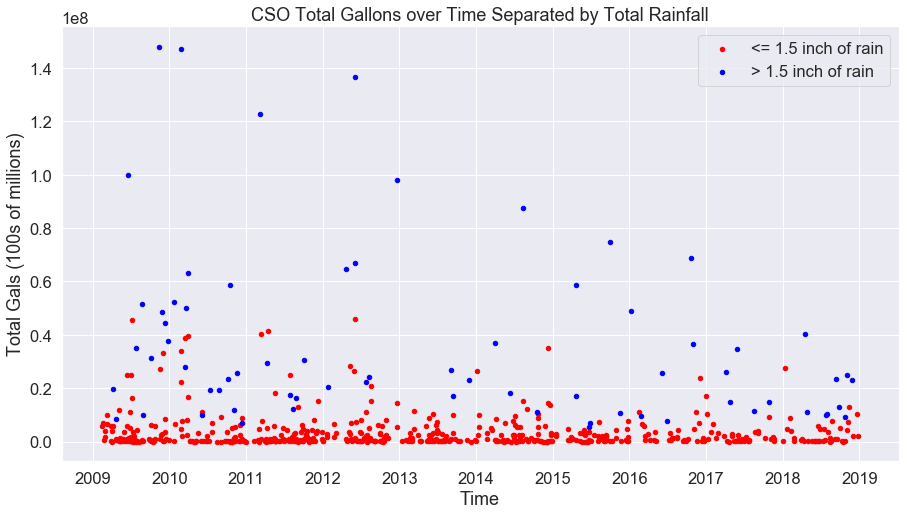

In [455]:
discharge_df_less1_5 = discharge_df[discharge_df[inches] <= 1.5]
discharge_df_more1_5 = discharge_df[discharge_df[inches] > 1.5]

dates_less = pd.to_datetime(discharge_df_less1_5[date])
dates_more = pd.to_datetime(discharge_df_more1_5[date])

fig,ax = plt.subplots()
ax.set(xlabel=xlabel, ylabel='Total Gals (100s of millions)',
           title='CSO Total Gallons over Time Separated by Total Rainfall')

plt.scatter(dates_less, discharge_df_less1_5[discharge], s =20, c = 'red', label = '<= 1.5 inch of rain')
plt.scatter(dates_more, discharge_df_more1_5[discharge], s =20, c = 'blue', label = '> 1.5 inch of rain')
ax.legend()
ax.grid(True)
plt.show()

Before beginning it is useful to just examine the data as it is to look for patterns. As can be seen in the above graph the total amount of discharge in >1.5 inches of rain has been decreasing year after year. In the past when in heavy rainstorms everything would overflow, and the totals would be in the hundreds of millions per storm. Cresting a billion gallons of total CSO flow in some years.

This is directly due to the City's sewer/stormwater separation efforts where certain CSO outlets have been entirely removed from the system, and replaced by stormwater-only discharges and/or storage tanks. 

_______

_______

The goal is to determine if there is a way to forecast future CSO overflows to a reasonable degree. Or, barring that, at least fill in the gaps for when the CSO Meters must be removed for general maintenance. Given the nature of the data, it is assumed there are far more variables in play then just what is given in the spreadsheet. Sediment in the pipes, blockages, etc are all things that could impact the data at any one point in time. A more robust hydrological model would be needed to make a determination to a high degree of accuracy. 

The goal here is to be able to say to a reasonable degree that "with x amount of rain there will be a CSO within some range" could be helpful. Even if the specific CSO cannot be pinpointed, knowing that there will be a CSO event is handy. It is possible just hitting the same order of magnitude will work for lower values.

When plotting the order of magnitue vs the percent of the total events anything <= 10 million accounts for ~82% of the total events, and <= 1 million accounts for ~46% of the total events. So those would be two values to look at later on.

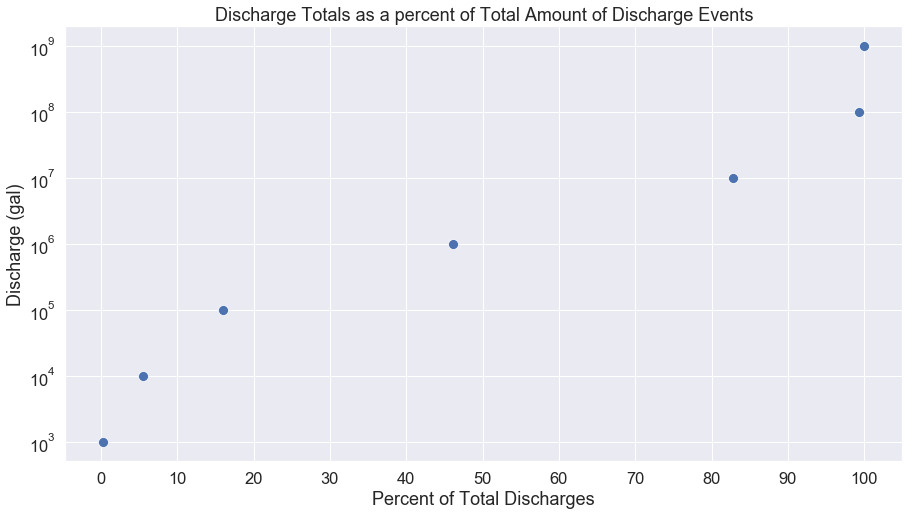

In [581]:
perc = []
total = []
for i in range(3,10):  # creating lists for the percent and order of magnitude
    discharge_df_mag = discharge_df[discharge_df[discharge] <= 10**i]
    perc.append(round(discharge_df_mag[discharge].count()/discharge_df[discharge].count()*100,3))
    total.append(10**i)

sns.scatterplot(perc,total, s = 100).set_yscale('log')  # scatter plot with log scale
sns.set(font_scale=1.5)

ax = plt.gca()
ax.set(xlabel = 'Percent of Total Discharges', ylabel= 'Discharge (gal)',
        title= 'Discharge Totals as a percent of Total Amount of Discharge Events')
ax.grid(True)

loc = plticker.MultipleLocator(base=10) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

_____

In [566]:
def abline(slope, intercept, rsquared):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    if rs >= 0.09:
        plt.plot(x_vals, y_vals, '--', c = 'black', label = "Slope with r^2 of %s" % rsquared)
    else:
        plt.plot(x_vals, y_vals, '--', c = 'black')
        
def graph_slope_rs(x, y, xlabel, ylabel, title, label):
    """
    plotting points with a slope, legend, titles, etc. 
    Note to self: In the future just use Seaborn as it does this in a much easier fashion.
    
    """
    try:
        rs = round(np.corrcoef(x, y)[0,1]**2,2)  # computing the rsquared
    except TypeError:
        rs = 0
    
    fig,ax = plt.subplots()
    ax.set(xlabel = xlabel, ylabel= ylabel,
           title= title)
    ax.grid(True)
    
    slope, intercept = np.polyfit(x, y, 1)  # computing the slope and intercept

    plt.scatter(x,y, c ='red', label = label)
    abline(slope,intercept, rs)  # plotting slope line
    ax.legend()
    plt.show()

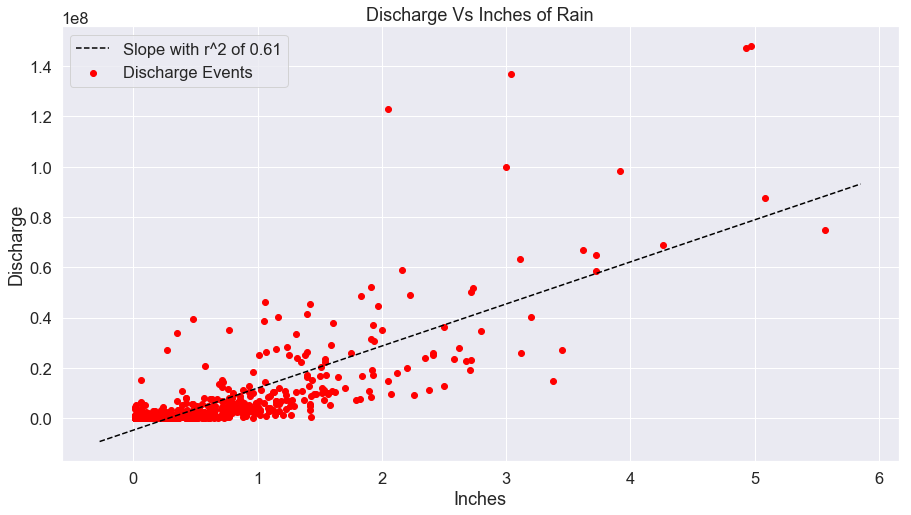

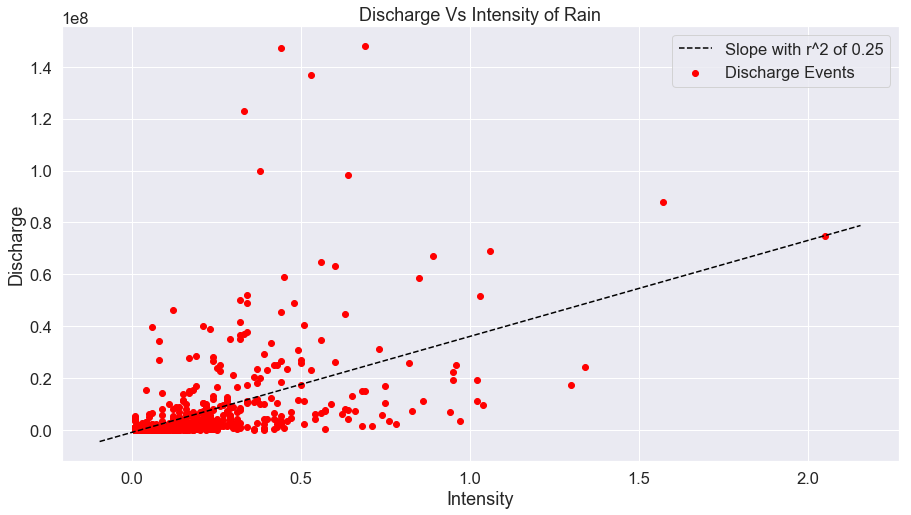

In [582]:
graph_slope_rs(discharge_df[inches],discharge_df[discharge],"Inches","Discharge", "Discharge Vs Inches of Rain", "Discharge Events")
graph_slope_rs(discharge_df[intensity],discharge_df[discharge],"Intensity","Discharge", "Discharge Vs Intensity of Rain","Discharge Events")

The total system discharge can be plotted against the inches of rain and intensity of rain separately, giving each a slope and rsquared.

With an rsquared of 0.61 the discharge vs inches data seems to correlate a whole lot more than the discharge vs intensity data, which had an rsquared of 0.21.
However, both are lower than desired for any kind of model. Next both variables can be added to the regression to see if the model can get any more accurate. 

Note: This is for system-wide CSO flow only. Flow specific to any one CSO will be discuss later (here or elsewhere).

Below this same model is applied to lower discharge values to see if the accuracy can be improved.

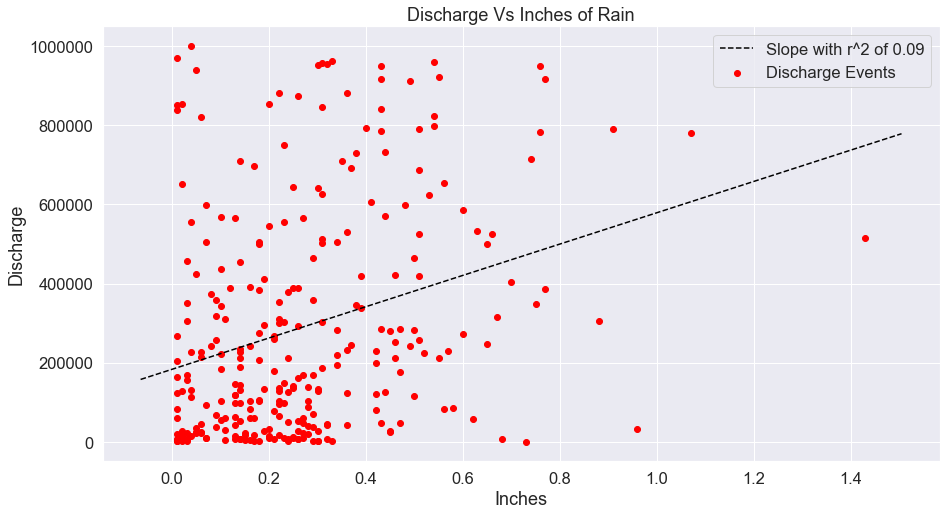

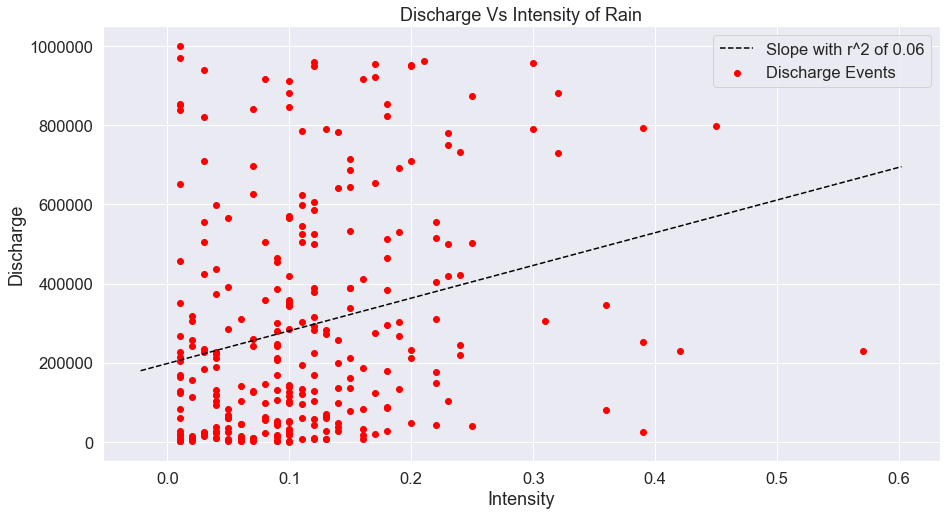

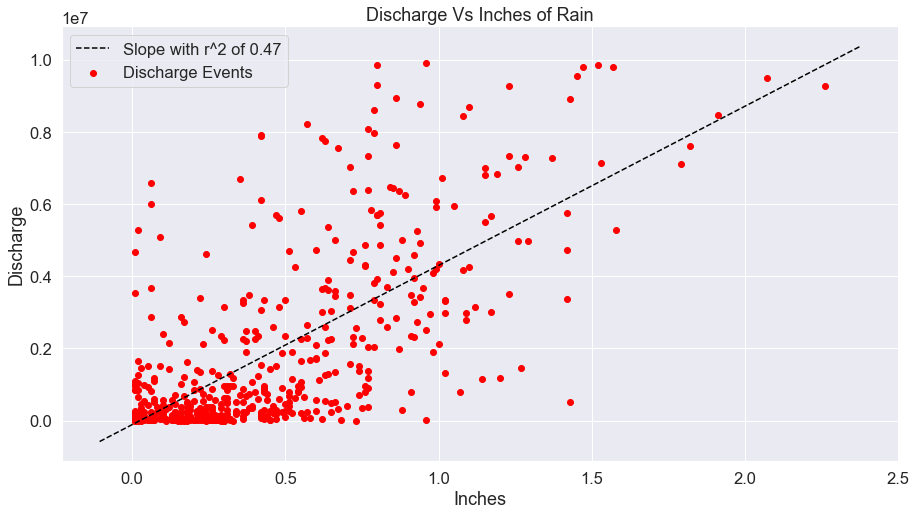

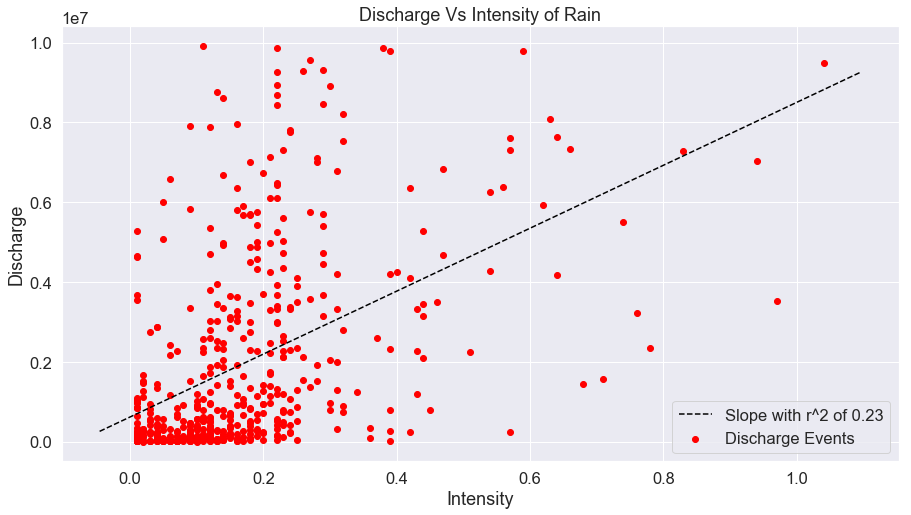

In [369]:
df_10_7 = discharge_df[discharge_df[discharge] <= 10**7]
df_10_6 = discharge_df[discharge_df[discharge] <= 10**6]

graph_slope_rs(df_10_6[inches],df_10_6[discharge],"Inches","Discharge", "Discharge Vs Inches of Rain", "Discharge Events")
graph_slope_rs(df_10_6[intensity],df_10_6[discharge],"Intensity","Discharge", "Discharge Vs Intensity of Rain","Discharge Events")

graph_slope_rs(df_10_7[inches],df_10_7[discharge],"Inches","Discharge", "Discharge Vs Inches of Rain", "Discharge Events")
graph_slope_rs(df_10_7[intensity],df_10_7[discharge],"Intensity","Discharge", "Discharge Vs Intensity of Rain","Discharge Events")

It becomes immediately apparent that attempting to form a direct linear relationship between discharge and any one variable is fruitless once discharge is plotted against inches and then intensity at values lower <= 10 million and <= 1 million. At this point there would be a better chance of correctly guessing the value by throwing a dart at a dart board.

But hopefully since the model is simply an attempt to predict whether or not a CSO wil occur and in which order of magnitude it will be, a lack of a linear relationship in either of these scenerios may not sink it yet.

_______

Next stage is to use both inches and intensity variables in a regression to try and determine a better model. Since the regression is now looking at two variables it is necessary to start with all of the discharge data, to prevent changing too many factors at once.

In [457]:
y = discharge_df[discharge] 
x = discharge_df[[inches,intensity]]

regr = linear_model.LinearRegression(fit_intercept = False)  # if intercept isnt set to false there are negative values
regr.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [635]:
def magnitude(x):
    return int(math.log10(x))

def predict_vals(dataframe_predict, magnitude_text):
    order_mag_y = 0
    order_mag_n = 0
    left_over = 0

    for index, row in dataframe_predict.iterrows():
        prediction = float(''.join(map(str, regr.predict([[row['Inches'],row['Intensity']]]))))
        if prediction >= 0:

            if magnitude(row['Discharge']) == magnitude(pd.to_numeric(''.join(map(str, regr.predict([[row['Inches'],row['Intensity']]]))))):
                order_mag_y += 1
            else:
                order_mag_n += 1

            dataframe_predict.at[index,'Prediction'] = prediction
        else:
            left_over += 1
            dataframe_predict.at[index,'Prediction'] = float(0)
    print('Calculating for {} values.'.format(magnitude_text))
    print('Same order of magnitude:', order_mag_y,'| Incorrect order of magnitude:', order_mag_n, '| Leftover:',left_over)
    percent_correct = order_mag_y/(order_mag_y+order_mag_n+left_over)*100
    print('Percent Correct:',round(percent_correct))
    print()

predict_vals(discharge_df, 'all')

Calculating for all values.
Same order of magnitude: 233 | Incorrect order of magnitude: 337 | Leftover: 43
Percent Correct: 38



Fitting all of the discharge data to the regression leaves the prediction with 233 values in the same order of magnitude as the actual discharge, 337 outside the order of magnitude, and 43 left over. The left overs are values that the regession set to below zero, and had to be adjusted to 0. With this model the correct values make up 38% of the total predici

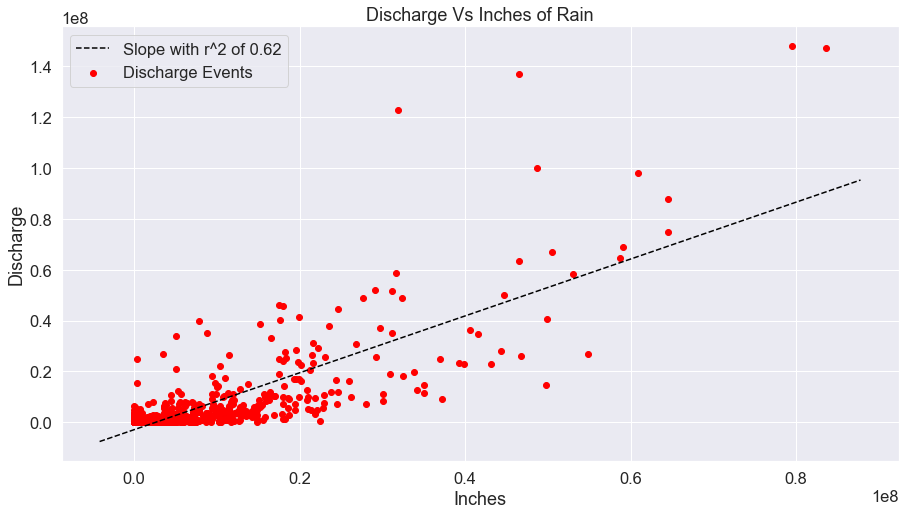

In [597]:
graph_slope_rs(pd.to_numeric(discharge_df['Prediction']),discharge_df[discharge],"Inches","Discharge", "Discharge Vs Inches of Rain", "Discharge Events")

With an rsquared of 0.62, despite missing the correct order of magnitude, the regression model is closer to the mark than the attempts at simply reducing the data to smaller discharge values, as seen in the graph above.

In the graph below the same data is plotted as the graph above, however the x and y axis are set to a log scale to get a better understanding of how the data is distributed. The black line is where we would want our data if the regression model resulted in perfect predictions. Here it can be seen how the model overshoots. Actual values hovering around 1e6 are computed to be around 1e7 by the model. To be more positive about the results, it is better to overshoot a CSO prediciton than undershoot it - at least for the people dealing with the overflows. 

Just by first impressions, it looks like the model actually gets more accurate as the numbers increase, going against the first guess earlier on in the notebook.

In [627]:
def log_plot(dataframe_log, title):
    sns.scatterplot(x = 'Prediction', y = discharge, s = 100, data =dataframe_log, label = 'Events')  # scatter plot with log scale
    plt.xlim(1e2, 1e9)
    plt.xscale('log')
    plt.ylim(1e2, 1e9)
    plt.yscale('log')
    slope, intercept = np.polyfit([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], 1)  # computing the slope and intercept
    rsquared = round(np.corrcoef([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9], [1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9])[0,1]**2,2)  # computing the rsquared
    abline(slope,intercept, rsquared)

    ax = plt.gca()
    ax.set(xlabel = 'Predicted Discharge (gal)', ylabel= ' Actual Discharge (gal)',
            title= title)
    ax.grid(True)
    #ax.legend()
    plt.show()

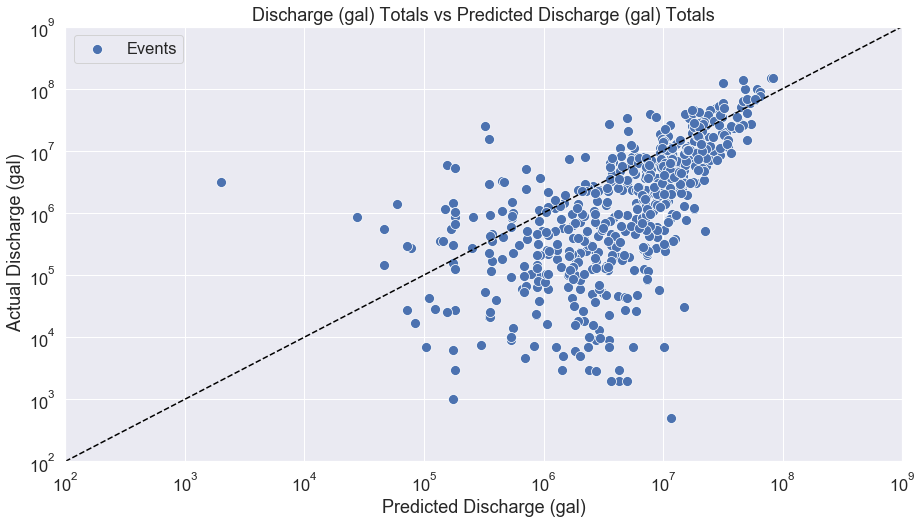

In [628]:
log_plot(discharge_df, 'Discharge (gal) Totals vs Predicted Discharge (gal) Totals')

In [636]:
discharge_df_lesstest = discharge_df[discharge_df[discharge] <= 10**6]
discharge_df_evenlesstest = discharge_df[discharge_df[discharge] <= 10**5]
discharge_df_hightest = discharge_df[discharge_df[discharge] >= 10**7]

predict_vals(discharge_df_lesstest, '1e6 and under')
predict_vals(discharge_df_evenlesstest, '1e5 and under')
predict_vals(discharge_df_hightest, '1e7 and over')

Calculating for 1e6 and under values.
Same order of magnitude: 38 | Incorrect order of magnitude: 215 | Leftover: 30
Percent Correct: 13

Calculating for 1e5 and under values.
Same order of magnitude: 2 | Incorrect order of magnitude: 85 | Leftover: 11
Percent Correct: 2

Calculating for 1e7 and over values.
Same order of magnitude: 86 | Incorrect order of magnitude: 19 | Leftover: 0
Percent Correct: 82



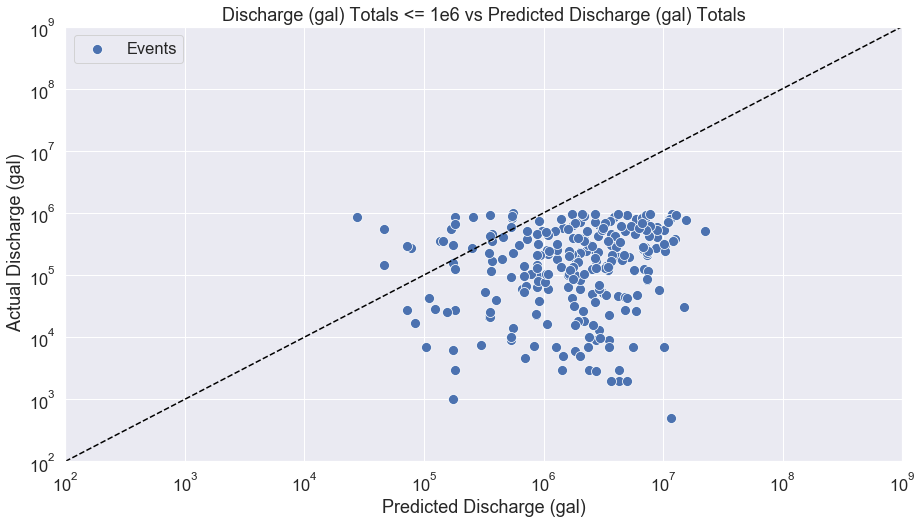

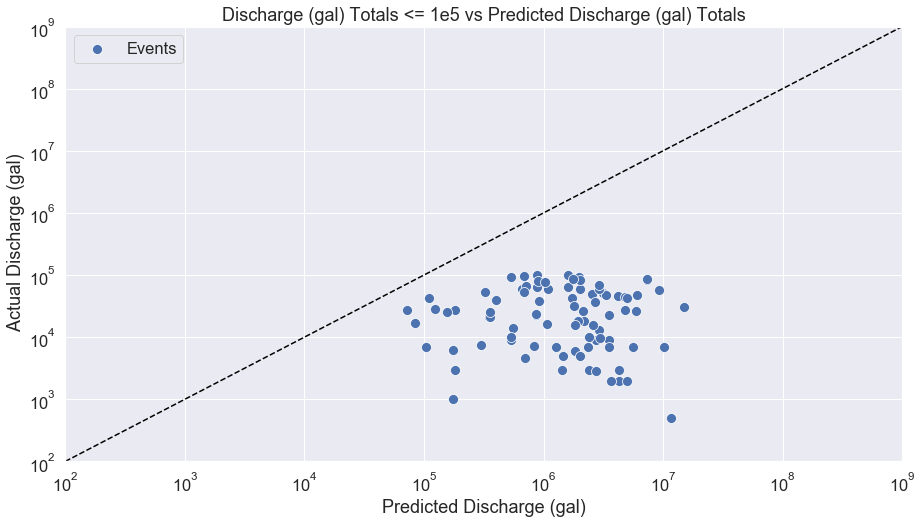

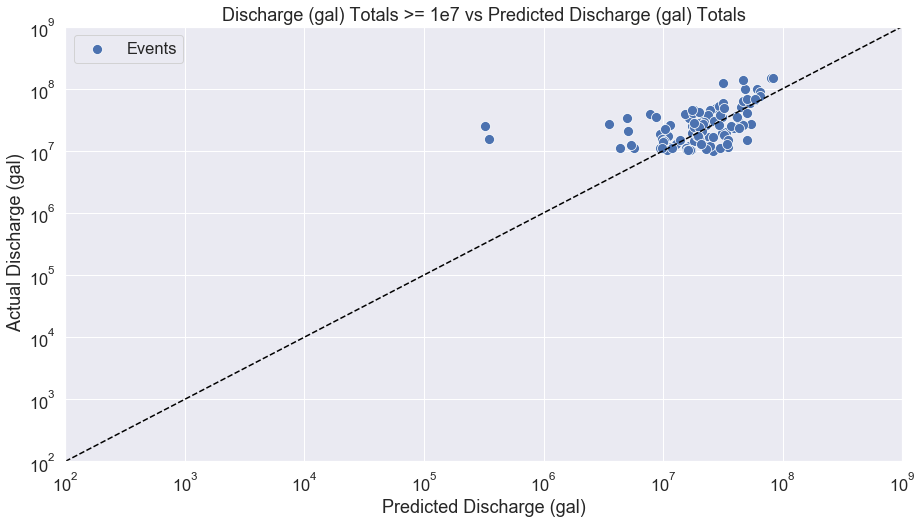

In [638]:
log_plot(discharge_df_lesstest, 'Discharge (gal) Totals <= 1e6 vs Predicted Discharge (gal) Totals')
log_plot(discharge_df_evenlesstest, 'Discharge (gal) Totals <= 1e5 vs Predicted Discharge (gal) Totals')
log_plot(discharge_df_hightest, 'Discharge (gal) Totals >= 1e7 vs Predicted Discharge (gal) Totals')

The pitfalls of the model at lower values becomes very apparent when examining just the lower discharge values. When the <= 100,000 and <= 1 million datasets are applied to the model it overshoots by 2 orders of magnitude in some cases.

The model does accurately predictt the order of magnitude for 82% of the discharge values when only examining >= 10 million values. So it really turns out the assumptions at the beginning were entirely the opposite of what is happening. The >= 10 million values make up less than 20% of the dataset, so it is not too helpful to be able to accuraltely guess them, coupled with the fact that sewer separation and storage efforts will continue to decrease the total discharge volume per event.

_____